# L2 – Multilayer perceptron

### PyTorch
1. [Installing PyTorch](https://pytorch.org/get-started/locally/)
2. [What is PyTorch?](https://pytorch.org/tutorials/beginner/blitz/tensor_tutorial.html#sphx-glr-beginner-blitz-tensor-tutorial-py)
3. [Autograd](https://pytorch.org/tutorials/beginner/blitz/autograd_tutorial.html#sphx-glr-beginner-blitz-autograd-tutorial-py)
4. [Useful examples](https://pytorch.org/tutorials/beginner/pytorch_with_examples.html)
5. [Mnist example](https://habr.com/company/otus/blog/358096/)


### One more thing
1. [Jupyter tutorial](https://habrahabr.ru/company/wunderfund/blog/316826/)
2. [Plot.ly](https://plot.ly/python/)
3. [Widgets](http://jupyter.org/widgets.html)

# Pytorch

### 1. Linear multi-classification problem

We have already learned binary linear classifier
$$y = \text{sign}(w^Tx).$$
There are [several approaches](https://en.wikipedia.org/wiki/Multiclass_classification) to solve the problem of multi-class classification. For example [reduction](https://en.wikipedia.org/wiki/Multiclass_classification#Transformation_to_Binary) of problem to binary classifier or [modification](https://en.wikipedia.org/wiki/Support_vector_machine#Multiclass_SVM) of the known model. However we are interested in approaches that is applied in neural networks.

For each class $c \in 1, \dots, |C|$ we have an individual row $w_i$ of matrix $W$. Then the probability of $x$ belonging to a particular class is equal to
$$p_i = \frac{\exp(w^T_ix)}{\sum_j \exp(w^T_jx)}.$$
This is nothing, but [softmax](https://en.wikipedia.org/wiki/Softmax_function) function of $Wx$.
$$(p_1, \dots, p_{|C|}) = \text{softmax}(Wx).$$

If you look closely, $\text{softmax}$ is a more general variant of sigmoid. To see this, it suffices to consider the case $|C|=2$. As usual the training can be reduced to minimization of the empirical risk, namely, optimization problem
$$\arg\min_W Q(W) = \arg\min_W -\frac{1}{\mathcal{l}}\sum_y\sum_i [y = i] \cdot \ln(p_i(W)).$$
Actually, the maximization of the log-likelihood is written above.

#### Exercises
1. Find $\frac{dQ}{dW}$ in matrix form (hint: start with $\frac{dQ}{dw_i}$ for begining).
2. Please plot several mnist images (e.g using grid 5x5).
3. Train linear multi-label classifier for [mnist](https://www.kaggle.com/c/digit-recognizer) dataset (possible, [this tutorial](https://habr.com/company/otus/blog/358096/) can help you).
4. Chek accuracy on train and validation sets (visualize resulted graph).

In [2]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [3]:
# Import Libraries
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.autograd import Variable
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

In [6]:
# Prepare Dataset
# load data
train = pd.read_csv(r"mnist_input/train.csv", dtype=np.float32)
print(train.info())

# split data into features(pixels) and labels(numbers from 0 to 9)
targets_numpy = train.label.values
features_numpy = train.loc[:,train.columns != "label"].values / 255 # normalization
print("targets numpy: {}".format(targets_numpy.shape))
print("features numpy: {}".format(features_numpy.shape))


# train test split. Size of train data is 80% and size of test data is 20%. 
features_train, features_test, targets_train, targets_test = train_test_split(features_numpy,
                                                                             targets_numpy,
                                                                             test_size=0.2,
                                                                             random_state=42) 

print("!!!", features_train)
print(type(features_train))
print("???", type(features_train[0][0]))
# create feature and targets tensor for train set. As you remember we need variable to accumulate gradients. Therefore first we create tensor, then we will create variable
featuresTrain = torch.from_numpy(features_train)
targetsTrain = torch.from_numpy(targets_train).type(torch.LongTensor) # data type is long
print("features train: {}\n".format(featuresTrain.shape))
print("targets train: {}\n".format(targetsTrain.shape))

# create feature and targets tensor for test set.
featuresTest = torch.from_numpy(features_test)
targetsTest = torch.from_numpy(targets_test).type(torch.LongTensor) # data type is long
print("features test: {}\n".format(featuresTest.shape))
print("targets test: {}\n".format(targetsTest.shape))

# batch_size, epoch and iteration
batch_size = 100
n_iters = 10000
num_epochs = 100
num_epochs = int(num_epochs)

# Pytorch train and test sets
train = torch.utils.data.TensorDataset(featuresTrain, targetsTrain)
test = torch.utils.data.TensorDataset(featuresTest, targetsTest)

# data loader
# https://pytorch.org/tutorials/beginner/data_loading_tutorial.html
# We do not set up shuffle to true as it was already shuffled by train_test_split
train_loader = torch.utils.data.DataLoader(train, batch_size = batch_size)
test_loader = torch.utils.data.DataLoader(test, batch_size = batch_size)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42000 entries, 0 to 41999
Columns: 785 entries, label to pixel783
dtypes: float32(785)
memory usage: 125.8 MB
None
targets numpy: (42000,)
features numpy: (42000, 784)
!!! [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
<class 'numpy.ndarray'>
??? <class 'numpy.float32'>
features train: torch.Size([33600, 784])

targets train: torch.Size([33600])

features test: torch.Size([8400, 784])

targets test: torch.Size([8400])



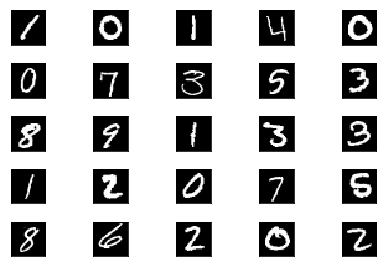

In [288]:
# visualize several of the images in data set
fig = plt.figure()
for i in range(25):
  plt.subplot(5,5,i+1)
  plt.tight_layout()
  plt.imshow(features_numpy[i].reshape(28, 28), cmap='gray', interpolation='none')
  plt.xticks([])
  plt.yticks([])

In [289]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.linear1 = nn.Linear(28*28, 10)
    
    def forward(self, x):
        out = self.linear1(x)
        return out

In [290]:
model = Net()
error = nn.CrossEntropyLoss()

learning_rate = 0.001
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

As we have 33600 samples, batch size is 100 then 1 epoch takes 336 iterations.

number of epochs - number of times the whole data is trained.

In [292]:
# Traning the Model
count = 0
log_period = 50
loss_list = []
iteration_list = []
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        # Define variables
        train = Variable(images.view(-1, 28*28))
        labels = Variable(labels)
        # Clear gradients
        optimizer.zero_grad()
        # Forward propagation
        outputs = model(train)
        # Calculate softmax and cross entropy loss
        loss = error(outputs, labels)
        # Calculate gradients
        loss.backward()
        # Update parameters
        optimizer.step()
        count += 1
        # Prediction
        if (count - 1) % log_period == 0:
            # Calculate Accuracy (for graphs later)         
            correct = 0
            total = 0
            # Predict test dataset
            for images, labels in test_loader: 
                test = Variable(images.view(-1, 28*28))
                # Forward propagation
                outputs = model(test)
                # Get predictions from the maximum value
                predicted = torch.max(outputs.data, 1)[1]
                # Total number of labels
                total += len(labels)
                # Total correct predictions
                correct += (predicted == labels).sum()
            accuracy = 100 * correct / float(total)
            # store loss and iteration
            loss_list.append(loss.data)
            iteration_list.append(count)
        if epoch % 3 == 0 and (count - 1) % 336 == 0:
            # Print Loss
            print('Epoch {}, Iteration: {}  Loss: {}  Accuracy: {}%'.format(epoch, count, loss.data, accuracy))

Epoch 0, Iteration: 1  Loss: 2.3356566429138184  Accuracy: 7%
Epoch 3, Iteration: 1009  Loss: 1.4951612949371338  Accuracy: 74%
Epoch 6, Iteration: 2017  Loss: 1.10698401927948  Accuracy: 79%
Epoch 9, Iteration: 3025  Loss: 0.9051502346992493  Accuracy: 82%
Epoch 12, Iteration: 4033  Loss: 0.7842991352081299  Accuracy: 82%
Epoch 15, Iteration: 5041  Loss: 0.7040551900863647  Accuracy: 83%
Epoch 18, Iteration: 6049  Loss: 0.6467719078063965  Accuracy: 84%
Epoch 21, Iteration: 7057  Loss: 0.6036975383758545  Accuracy: 84%
Epoch 24, Iteration: 8065  Loss: 0.5700324177742004  Accuracy: 85%
Epoch 27, Iteration: 9073  Loss: 0.5429304242134094  Accuracy: 85%
Epoch 30, Iteration: 10081  Loss: 0.5205958485603333  Accuracy: 85%
Epoch 33, Iteration: 11089  Loss: 0.5018393397331238  Accuracy: 86%
Epoch 36, Iteration: 12097  Loss: 0.48584043979644775  Accuracy: 86%
Epoch 39, Iteration: 13105  Loss: 0.47201481461524963  Accuracy: 86%
Epoch 42, Iteration: 14113  Loss: 0.4599330425262451  Accuracy: 86

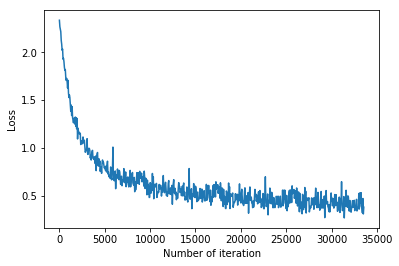

In [293]:
# visualization
plt.plot(iteration_list, loss_list)
plt.xlabel("Number of iteration")
plt.ylabel("Loss")
plt.show()

Let's briefly touch on themes of regularization. As was discussed before, there are different approaches. We focus on the modification of loss function.

$$\arg\min_W -\frac{1}{\mathcal{l}}\sum_y\sum_i [y = i] \cdot \ln(p_i(W)) + \lambda_1 L_1(W) + \lambda_2 L_2(W)$$

1. $L_1(W) = sum_{i,j} |w_{i,j}|$ - sparsify weights (force to not use uncorrelated features)
2. $L_2(W) = sum_{i,j} w_{i,j}^2$ - minimize weights (force to not overfit)

#### Exercises
1. Train model again using both type of regularization.
2. Plot matrix of weights.
3. Which pixels have zero weights? What does it mean?
4. Have you improved accuracy on validation?

## Adding regularization

In [311]:
model = Net()
error = nn.CrossEntropyLoss()
lambda1 = 0.001
lambda2 = 0.001

learning_rate = 0.001
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [312]:
# Traning the Model
count = 0
log_period = 50
loss_list = []
iteration_list = []
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        # Define variables
        train = Variable(images.view(-1, 28*28))
        labels = Variable(labels)
        # Clear gradients
        optimizer.zero_grad()
        # Forward propagation
        outputs = model(train)
        # Calculate softmax and cross entropy loss
        loss = error(outputs, labels)
        L1Loss, L2Loss = 0, 0
        for row in model.linear1.weight:
            L1Loss += torch.sum(torch.abs(row))
            L2Loss += torch.sum(row ** 2)   
        loss += lambda1 * L1Loss + lambda2 * L2Loss
        # Calculate gradients
        loss.backward()
        # Update parameters
        optimizer.step()
        count += 1
        # Prediction
        if (count - 1) % log_period == 0:
            # Calculate Accuracy (for graphs later)         
            correct = 0
            total = 0
            # Predict test dataset
            for images, labels in test_loader: 
                test = Variable(images.view(-1, 28*28))
                # Forward propagation
                outputs = model(test)
                # Get predictions from the maximum value
                predicted = torch.max(outputs.data, 1)[1]
                # Total number of labels
                total += len(labels)
                # Total correct predictions
                correct += (predicted == labels).sum()
            accuracy = 100 * correct / float(total)
            # store loss and iteration
            loss_list.append(loss.data)
            iteration_list.append(count)
        if epoch % 3 == 0 and (count - 1) % 336 == 0:
            # Print Loss
            print('Epoch {}, Iteration: {}  Loss: {}  Accuracy: {}%'.format(epoch, count, loss.data, accuracy))

Epoch 0, Iteration: 1  Loss: 2.4606738090515137  Accuracy: 12%
Epoch 3, Iteration: 1009  Loss: 1.636593222618103  Accuracy: 76%
Epoch 6, Iteration: 2017  Loss: 1.2750190496444702  Accuracy: 80%
Epoch 9, Iteration: 3025  Loss: 1.0918614864349365  Accuracy: 82%
Epoch 12, Iteration: 4033  Loss: 0.9843042492866516  Accuracy: 83%
Epoch 15, Iteration: 5041  Loss: 0.9138143658638  Accuracy: 83%
Epoch 18, Iteration: 6049  Loss: 0.8639422655105591  Accuracy: 84%
Epoch 21, Iteration: 7057  Loss: 0.8266137838363647  Accuracy: 84%
Epoch 24, Iteration: 8065  Loss: 0.7976602911949158  Accuracy: 85%
Epoch 27, Iteration: 9073  Loss: 0.7744062542915344  Accuracy: 85%
Epoch 30, Iteration: 10081  Loss: 0.7552582621574402  Accuracy: 85%
Epoch 33, Iteration: 11089  Loss: 0.7392275929450989  Accuracy: 85%
Epoch 36, Iteration: 12097  Loss: 0.7254965305328369  Accuracy: 86%
Epoch 39, Iteration: 13105  Loss: 0.7136600017547607  Accuracy: 86%
Epoch 42, Iteration: 14113  Loss: 0.7033464312553406  Accuracy: 86%
E

It isn't better so lets return to the previous model

In [313]:
model = Net()
error = nn.CrossEntropyLoss()

learning_rate = 0.001
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [314]:
# Traning the Model
count = 0
log_period = 50
loss_list = []
iteration_list = []
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        # Define variables
        train = Variable(images.view(-1, 28*28))
        labels = Variable(labels)
        # Clear gradients
        optimizer.zero_grad()
        # Forward propagation
        outputs = model(train)
        # Calculate softmax and cross entropy loss
        loss = error(outputs, labels)
        # Calculate gradients
        loss.backward()
        # Update parameters
        optimizer.step()
        count += 1
        # Prediction
        if (count - 1) % log_period == 0:
            # Calculate Accuracy (for graphs later)         
            correct = 0
            total = 0
            # Predict test dataset
            for images, labels in test_loader: 
                test = Variable(images.view(-1, 28*28))
                # Forward propagation
                outputs = model(test)
                # Get predictions from the maximum value
                predicted = torch.max(outputs.data, 1)[1]
                # Total number of labels
                total += len(labels)
                # Total correct predictions
                correct += (predicted == labels).sum()
            accuracy = 100 * correct / float(total)
            # store loss and iteration
            loss_list.append(loss.data)
            iteration_list.append(count)
        if epoch % 3 == 0 and (count - 1) % 336 == 0:
            # Print Loss
            print('Epoch {}, Iteration: {}  Loss: {}  Accuracy: {}%'.format(epoch, count, loss.data, accuracy))

Epoch 0, Iteration: 1  Loss: 2.3198909759521484  Accuracy: 8%
Epoch 3, Iteration: 1009  Loss: 1.4847216606140137  Accuracy: 76%
Epoch 6, Iteration: 2017  Loss: 1.098168134689331  Accuracy: 80%
Epoch 9, Iteration: 3025  Loss: 0.8974569439888  Accuracy: 82%
Epoch 12, Iteration: 4033  Loss: 0.7776815891265869  Accuracy: 82%
Epoch 15, Iteration: 5041  Loss: 0.6983141899108887  Accuracy: 83%
Epoch 18, Iteration: 6049  Loss: 0.6417055726051331  Accuracy: 84%
Epoch 21, Iteration: 7057  Loss: 0.5991445183753967  Accuracy: 84%
Epoch 24, Iteration: 8065  Loss: 0.5658730864524841  Accuracy: 85%
Epoch 27, Iteration: 9073  Loss: 0.539077639579773  Accuracy: 85%
Epoch 30, Iteration: 10081  Loss: 0.5169862508773804  Accuracy: 85%
Epoch 33, Iteration: 11089  Loss: 0.4984265863895416  Accuracy: 86%
Epoch 36, Iteration: 12097  Loss: 0.4825902283191681  Accuracy: 86%
Epoch 39, Iteration: 13105  Loss: 0.4689016342163086  Accuracy: 86%
Epoch 42, Iteration: 14113  Loss: 0.4569380581378937  Accuracy: 86%
Epo

## Weights plot

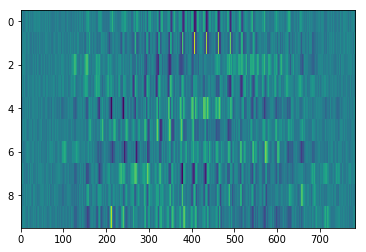

In [354]:
plt.imshow(model.linear1.weight.detach().numpy(), aspect='auto')

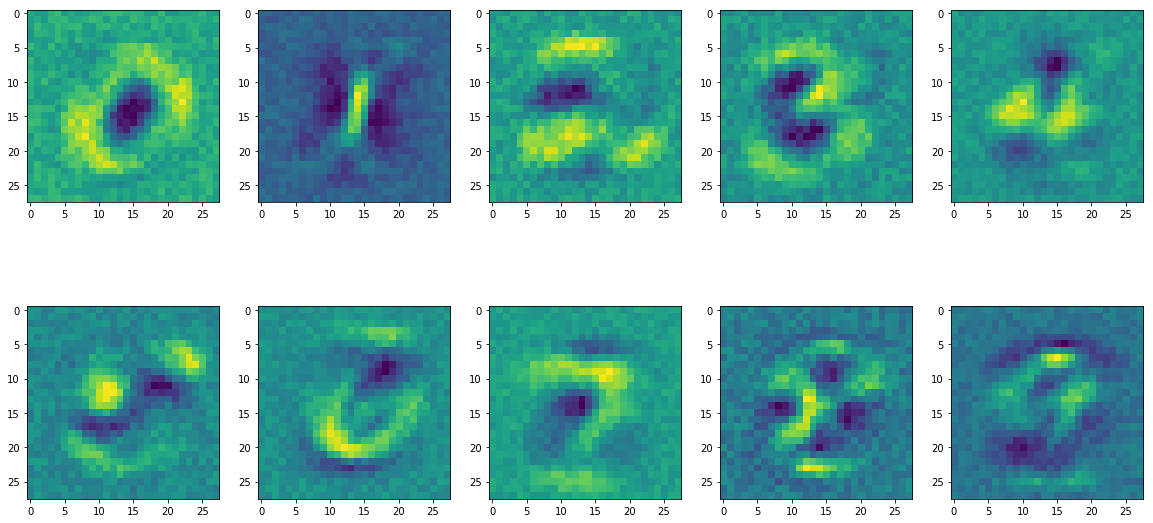

In [362]:
plt.figure(figsize=(20,10))
for i in range(2):
    for j in range(5):
        plt.subplot2grid((2,5), (i, j))
        plt.imshow(model.linear1.weight[i * 5 + j].detach().numpy().reshape(28, 28))
plt.show()

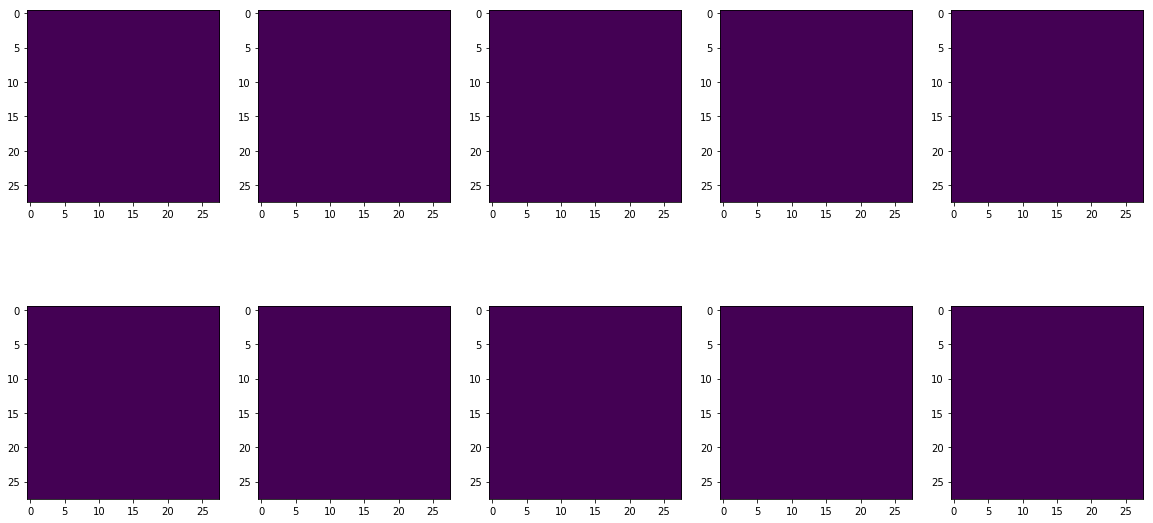

In [364]:
from copy import deepcopy
matrix = deepcopy(model.linear1.weight)
for i in range(len(matrix)):
    for j in range(len(matrix[i])):
        matrix[i][j] = (matrix[i][j] == 0)

plt.figure(figsize=(20,10))
for i in range(2):
    for j in range(5):
        plt.subplot2grid((2,5), (i, j))
        plt.imshow(matrix[i * 5 + j].detach().numpy().reshape(28, 28))
plt.show()

As we can see: no zeros

### 2. Universal approximation theorem

What if we add more layers to our model? Namely, we train two matrix $W_2$ and $W_1$
$$softmax(W_2\cdot(W_1x)).$$

At first glance adding more parameters helps to increase the generalizing ability of the model. Buy actually we have the same model $softmax(Wx)$, where $W = W_2\cdot W_1$. But everyting changes with adding ome more layer. Let's add nonlinear function $\sigma$ between $W_2$ and $W_1$

$$softmax(W_2\cdot \sigma(W_1x)).$$

Kurt Hornik showed in 1991 that it is not the specific choice of the nonlinear function, but rather the multilayer feedforward architecture itself which gives neural networks the potential of being universal approximators. The output units are always assumed to be linear. For notational convenience, only the single output case will be shown. The general case can easily be deduced from the single output case.

Let $\sigma(\cdot)$ be a nonconstant, bounded, and monotonically-increasing continuous function.
Let $\mathcal{S}_m \subset \mathbb{R}^m$ denote any compact set. 
Then, given any $\varepsilon > 0$ and any coninuous function $f$ on $\mathcal{S}_m$, there exist an integer $N$ and real constants $v_i$, $b_i$ amd real vectors $w_i$ that

$$\left| \sum _{i=1}^{N}v_{i}\sigma \left( w_i^{T} x+b_i \right) - f(x) \right| < \varepsilon, ~~~ \forall x \in \mathcal{S}_m.$$

The theorem has non-constructive proof, it meams that no estimates for $N$ and no method to find approximation's parameters.

#### Exercises
1. Let $\sigma$ – [heaviside step function](https://en.wikipedia.org/wiki/Heaviside_step_function) and $x \in \{0, 1\}^2$. Prove that $y = \sigma(wx + b)$ can approximate boolean function **OR** (hint: use constructive proof).
2. What about **AND** function?
3. Is it possible to implement **XOR**? Prove your words.
4. Prove that 2-layer network can implement any boolean function.

#### More useful facts:
1. A 2-layer network in in $\mathbb{R}^n$ allows to define convex polyhedron..
2. A 3-layer network in в $\mathbb{R}^n$ allows to define a not necessarily convex and not even necessarily connected area.

### 3. Backpropagation
Backpropagation is a method used to calculate the error contribution of each layer after a batch of data. It is a special case of an older and more general technique called automatic differentiation. In the context of learning, backpropagation is commonly used by the gradient descent optimization algorithm to adjust the weight of layers by calculating the gradient of the loss function. This technique is also sometimes called backward propagation of errors, because the error is calculated at the output and distributed back through the network layers. The main motivation of method is simplify evaluation of gradient which is complex problem for multilayer nets.

We need the following notation. Let $(y^1,\dots,y^n) = f(x^1,\dots,x^n)$ is some differentiable function and $\frac{dy}{dx}$ is matrix
$$\frac{dy}{dx} = \Big[ J_{ij} = \frac{\partial y^i}{\partial x^j} \Big]$$

Without violating the generality, we can assume that each layer is a function $x_{i} = f(x_{i-1}, w_i)$. As last layer we add loss function, so we can assume our multi-layer net as function $Q(x_0) = Q(f_n(f_{n-1}(\dots, w_{n-1}), w_n))$.

#### Forward step
Propagation forward through the network to generate the output values. Calculation of the loss function.

#### Backward step
Let's look at last layer. We can simply find $\frac{dQ}{dx_n}$. Now we can evaluate 

$$\frac{dQ}{dw_n} = \frac{dQ}{dx_n}\frac{dx_n}{dw_n} \text{ and } \frac{dQ}{dx_{n-1}} = \frac{dQ}{dx_n}\frac{dx_n}{dx_{n-1}}$$

Now we need calculate $\frac{dQ}{dw_{n-2}}$ и $\frac{dQ}{dx_{n-2}}$. But we have the same situation. We know $\frac{dQ}{dx_k}$, so can evaluate $\frac{dQ}{dw_k}$ and $\frac{dQ}{dx_{k-1}}$. Repeating this operation we find all the gradients. Now it's only remains to make a gradient step to update weights.

#### Exercises
1. Read more about [vanishing gradient](https://en.wikipedia.org/wiki/Vanishing_gradient_problem).
2. Train 2 layer net. Use sigmoid as nonlinearity.
3. Check accuracy on validation set.
4. Use [ReLu](https://en.wikipedia.org/wiki/Rectifier_(neural_networks) or LeakyReLu as nonlinearity. Compare accuracy and convergence with previous model.
5. Play with different architectures (add more layers, regularization and etc).
6. Show your best model.
7. How does quality change with adding layers. Prove your words, train model for 2, 3, 5, 7 and 10 layers.
8. Using backpropagation find optimal  digit 8 for your net.*

In [388]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [432]:
# Import Libraries
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.autograd import Variable
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F

In [394]:
# Prepare Dataset
# load data
train = pd.read_csv(r"mnist_input/train.csv", dtype=np.float32)
print(train.info())

# split data into features(pixels) and labels(numbers from 0 to 9)
targets_numpy = train.label.values
features_numpy = train.loc[:,train.columns != "label"].values / 255 # normalization
print("targets numpy: {}".format(targets_numpy.shape))
print("features numpy: {}".format(features_numpy.shape))


# train test split. Size of train data is 80% and size of test data is 20%. 
features_train, features_test, targets_train, targets_test = train_test_split(features_numpy,
                                                                             targets_numpy,
                                                                             test_size=0.2,
                                                                             random_state=42) 

# create feature and targets tensor for train set. As you remember we need variable to accumulate gradients. Therefore first we create tensor, then we will create variable
featuresTrain = torch.from_numpy(features_train)
targetsTrain = torch.from_numpy(targets_train).type(torch.LongTensor) # data type is long
print("features train: {}\n".format(featuresTrain.shape))
print("targets train: {}\n".format(targetsTrain.shape))

# create feature and targets tensor for test set.
featuresTest = torch.from_numpy(features_test)
targetsTest = torch.from_numpy(targets_test).type(torch.LongTensor) # data type is long
print("features test: {}\n".format(featuresTest.shape))
print("targets test: {}\n".format(targetsTest.shape))

# batch_size, epoch and iteration
batch_size = 100
n_iters = 10000
num_epochs = 100
num_epochs = int(num_epochs)

# Pytorch train and test sets
train = torch.utils.data.TensorDataset(featuresTrain, targetsTrain)
test = torch.utils.data.TensorDataset(featuresTest, targetsTest)

# data loader
# https://pytorch.org/tutorials/beginner/data_loading_tutorial.html
# We do not set up shuffle to true as it was already shuffled by train_test_split
train_loader = torch.utils.data.DataLoader(train, batch_size = batch_size)
test_loader = torch.utils.data.DataLoader(test, batch_size = batch_size)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42000 entries, 0 to 41999
Columns: 785 entries, label to pixel783
dtypes: float32(785)
memory usage: 125.8 MB
None
targets numpy: (42000,)
features numpy: (42000, 784)
features train: torch.Size([33600, 784])

targets train: torch.Size([33600])

features test: torch.Size([8400, 784])

targets test: torch.Size([8400])



In [433]:
class TwoLayerLinearNet(nn.Module):
    def __init__(self):
        super(TwoLayerLinearNet, self).__init__()
        self.linear1 = nn.Linear(28*28, 100)
        self.linear2 = nn.Linear(100, 10)
    
    def forward(self, x):
        out = self.linear2(self.linear1(x))
        return out
    
class ThreeLayerLinearNet(nn.Module):
    def __init__(self):
        super(ThreeLayerLinearNet, self).__init__()
        self.linear1 = nn.Linear(28*28, 100)
        self.linear2 = nn.Linear(100, 50)
        self.linear3 = nn.Linear(50, 10)
    
    def forward(self, x):
        out = self.linear3(self.linear2(self.linear1(x)))
        return out

In [399]:
num_epochs = 60
num_epochs = int(num_epochs)

learning_rate = 0.001

In [434]:
def train(model, error, optimizer):
    # Traning the Model
    count = 0
    log_period = 50
    loss_list = []
    iteration_list = []
    for epoch in range(num_epochs):
        for i, (images, labels) in enumerate(train_loader):
            # Define variables
            train = Variable(images.view(-1, 28*28))
            labels = Variable(labels)
            # Clear gradients
            optimizer.zero_grad()
            # Forward propagation
            outputs = model(train)
            # Calculate softmax and cross entropy loss
            loss = error(outputs, labels)
            # Calculate gradients
            loss.backward()
            # Update parameters
            optimizer.step()
            count += 1
            # Prediction
            if (count - 1) % log_period == 0:
                # Calculate Accuracy (for graphs later)         
                correct = 0
                total = 0
                # Predict test dataset
                for images, labels in test_loader: 
                    test = Variable(images.view(-1, 28*28))
                    # Forward propagation
                    outputs = model(test)
                    # Get predictions from the maximum value
                    predicted = torch.max(outputs.data, 1)[1]
                    # Total number of labels
                    total += len(labels)
                    # Total correct predictions
                    correct += (predicted == labels).sum()
                accuracy = 100 * correct / float(total)
                # store loss and iteration
                loss_list.append(loss.data)
                iteration_list.append(count)
            if epoch % 3 == 0 and (count - 1) % 336 == 0:
                # Print Loss
                print('Epoch {}, Iteration: {}  Loss: {}  Accuracy: {}%'.format(epoch, count, loss.data, accuracy))

In [489]:
learning_rate = 0.01
num_epochs = 50
two_layer_linear_net = TwoLayerLinearNet()
two_layer_linear_error = nn.CrossEntropyLoss()
two_layer_linear_optimizer = torch.optim.SGD(two_layer_linear_net.parameters(), lr=learning_rate)
train(two_layer_linear_net, two_layer_linear_error, two_layer_linear_optimizer)

Epoch 0, Iteration: 1  Loss: 2.3294641971588135  Accuracy: 12%
Epoch 3, Iteration: 1009  Loss: 0.4500657021999359  Accuracy: 86%
Epoch 6, Iteration: 2017  Loss: 0.321450799703598  Accuracy: 88%
Epoch 9, Iteration: 3025  Loss: 0.2863503694534302  Accuracy: 89%
Epoch 12, Iteration: 4033  Loss: 0.2693973779678345  Accuracy: 89%
Epoch 15, Iteration: 5041  Loss: 0.2588057816028595  Accuracy: 90%
Epoch 18, Iteration: 6049  Loss: 0.251211941242218  Accuracy: 90%
Epoch 21, Iteration: 7057  Loss: 0.2452930510044098  Accuracy: 90%
Epoch 24, Iteration: 8065  Loss: 0.24041929841041565  Accuracy: 91%
Epoch 27, Iteration: 9073  Loss: 0.2362470179796219  Accuracy: 91%
Epoch 30, Iteration: 10081  Loss: 0.23257024586200714  Accuracy: 91%
Epoch 33, Iteration: 11089  Loss: 0.22925575077533722  Accuracy: 91%
Epoch 36, Iteration: 12097  Loss: 0.22621415555477142  Accuracy: 91%
Epoch 39, Iteration: 13105  Loss: 0.223383828997612  Accuracy: 91%
Epoch 42, Iteration: 14113  Loss: 0.2207210659980774  Accuracy: 

In [490]:
learning_rate = 0.01
num_epochs = 50
three_layer_linear_net = ThreeLayerLinearNet()
three_layer_linear_error = nn.CrossEntropyLoss()
three_layer_linear_optimizer = torch.optim.SGD(three_layer_linear_net.parameters(), lr=learning_rate)
train(three_layer_linear_net, three_layer_linear_error, three_layer_linear_optimizer)

Epoch 0, Iteration: 1  Loss: 2.304287910461426  Accuracy: 10%
Epoch 3, Iteration: 1009  Loss: 0.4568483829498291  Accuracy: 84%
Epoch 6, Iteration: 2017  Loss: 0.2747062146663666  Accuracy: 88%
Epoch 9, Iteration: 3025  Loss: 0.2449067234992981  Accuracy: 89%
Epoch 12, Iteration: 4033  Loss: 0.23500271141529083  Accuracy: 90%
Epoch 15, Iteration: 5041  Loss: 0.23003767430782318  Accuracy: 90%
Epoch 18, Iteration: 6049  Loss: 0.22656947374343872  Accuracy: 91%
Epoch 21, Iteration: 7057  Loss: 0.2235412448644638  Accuracy: 91%
Epoch 24, Iteration: 8065  Loss: 0.22064414620399475  Accuracy: 91%
Epoch 27, Iteration: 9073  Loss: 0.21777500212192535  Accuracy: 91%
Epoch 30, Iteration: 10081  Loss: 0.21489040553569794  Accuracy: 91%
Epoch 33, Iteration: 11089  Loss: 0.21197563409805298  Accuracy: 91%
Epoch 36, Iteration: 12097  Loss: 0.20903578400611877  Accuracy: 91%
Epoch 39, Iteration: 13105  Loss: 0.20608827471733093  Accuracy: 91%
Epoch 42, Iteration: 14113  Loss: 0.2031569629907608  Acc

In [481]:
class SigmoidAndLinearNet(nn.Module):
    def __init__(self):
        super(SigmoidAndLinearNet, self).__init__()
        self.linear1 = nn.Linear(28*28, 50)
        self.sigm = nn.Sigmoid()
        self.linear2 = nn.Linear(50, 10)
    
    def forward(self, x):
        out = self.linear2(self.sigm(self.linear1(x)))
        return out
    
    
class ReLuAndLinearNet(nn.Module):
    def __init__(self):
        super(ReLuAndLinearNet, self).__init__()
        self.linear1 = nn.Linear(28*28, 100)
        self.linear2 = nn.Linear(100, 50)
        self.relu1 = nn.ReLU()
        self.relu2 = nn.LeakyReLU()
        self.linear3 = nn.Linear(50, 10)
    
    def forward(self, x):
        out = self.linear3(self.relu1(self.linear2(self.relu2(self.linear1(x)))))
        return out
    
    
class ExperimentalNet(nn.Module):
    def __init__(self):
        super(ExperimentalNet, self).__init__()
        self.linear1 = nn.Linear(28*28, 100)
        self.linear2 = nn.Linear(100, 100)
        self.relu1 = nn.ReLU()
        self.tanh = nn.Tanh()
        self.relu2 = nn.LeakyReLU()
        self.elu = nn.ELU()
        self.linear3 = nn.Linear(100, 100)
        self.linear4 = nn.Linear(100, 10)
    
    def forward(self, x):
        out = self.linear4(self.elu(self.linear3(self.tanh(self.linear2(self.relu1(self.linear1(x)))))))
        return out
    
    
class ExperimentalNet2(nn.Module):
    def __init__(self):
        super(ExperimentalNet2, self).__init__()
        self.linear1 = nn.Linear(28*28, 300)
        self.linear2 = nn.Linear(300, 300)
        self.relu1 = nn.ReLU()
        self.tanh = nn.Tanh()
        self.relu2 = nn.LeakyReLU()
        self.elu = nn.ELU()
        self.linear3 = nn.Linear(300, 100)
        self.linear4 = nn.Linear(100, 100)
        self.linear5 = nn.Linear(100, 10)
    
    def forward(self, x):
        out = self.linear5(self.elu(self.linear4(
            self.tanh(self.linear3(self.elu(self.linear2(self.relu1(self.linear1(x))))))
        )))
        return out

In [485]:
learning_rate = 0.01
num_epochs = 50
sigmoid_and_linear_net = SigmoidAndLinearNet()
sigmoid_and_linear_error = nn.CrossEntropyLoss()
sigmoid_and_linear_optimizer = torch.optim.SGD(sigmoid_and_linear_net.parameters(), lr=learning_rate)
train(sigmoid_and_linear_net, sigmoid_and_linear_error, sigmoid_and_linear_optimizer)

Epoch 0, Iteration: 1  Loss: 2.324115753173828  Accuracy: 10%
Epoch 3, Iteration: 1009  Loss: 1.8968820571899414  Accuracy: 62%
Epoch 6, Iteration: 2017  Loss: 1.2602367401123047  Accuracy: 73%
Epoch 9, Iteration: 3025  Loss: 0.8783667087554932  Accuracy: 79%
Epoch 12, Iteration: 4033  Loss: 0.6790421009063721  Accuracy: 82%
Epoch 15, Iteration: 5041  Loss: 0.5604228377342224  Accuracy: 84%
Epoch 18, Iteration: 6049  Loss: 0.48220089077949524  Accuracy: 86%
Epoch 21, Iteration: 7057  Loss: 0.42739173769950867  Accuracy: 87%
Epoch 24, Iteration: 8065  Loss: 0.3875897228717804  Accuracy: 87%
Epoch 27, Iteration: 9073  Loss: 0.3579484224319458  Accuracy: 88%
Epoch 30, Iteration: 10081  Loss: 0.3353649377822876  Accuracy: 88%
Epoch 33, Iteration: 11089  Loss: 0.31775400042533875  Accuracy: 88%
Epoch 36, Iteration: 12097  Loss: 0.30369094014167786  Accuracy: 89%
Epoch 39, Iteration: 13105  Loss: 0.292195200920105  Accuracy: 89%
Epoch 42, Iteration: 14113  Loss: 0.28258585929870605  Accuracy

In [486]:
learning_rate = 0.01
num_epochs = 50
relu_and_linear_net = ReLuAndLinearNet()
relu_and_linear_error = nn.CrossEntropyLoss()
relu_and_linear_optimizer = torch.optim.SGD(relu_and_linear_net.parameters(), lr=learning_rate)
train(relu_and_linear_net, relu_and_linear_error, relu_and_linear_optimizer)

Epoch 0, Iteration: 1  Loss: 2.3002357482910156  Accuracy: 11%
Epoch 3, Iteration: 1009  Loss: 0.6492135524749756  Accuracy: 80%
Epoch 6, Iteration: 2017  Loss: 0.31615135073661804  Accuracy: 87%
Epoch 9, Iteration: 3025  Loss: 0.26374882459640503  Accuracy: 89%
Epoch 12, Iteration: 4033  Loss: 0.24149402976036072  Accuracy: 90%
Epoch 15, Iteration: 5041  Loss: 0.2258473038673401  Accuracy: 90%
Epoch 18, Iteration: 6049  Loss: 0.21323560178279877  Accuracy: 91%
Epoch 21, Iteration: 7057  Loss: 0.20121292769908905  Accuracy: 92%
Epoch 24, Iteration: 8065  Loss: 0.18635103106498718  Accuracy: 92%
Epoch 27, Iteration: 9073  Loss: 0.16989047825336456  Accuracy: 92%
Epoch 30, Iteration: 10081  Loss: 0.15563099086284637  Accuracy: 93%
Epoch 33, Iteration: 11089  Loss: 0.14282912015914917  Accuracy: 93%
Epoch 36, Iteration: 12097  Loss: 0.13220888376235962  Accuracy: 93%
Epoch 39, Iteration: 13105  Loss: 0.12267173826694489  Accuracy: 94%
Epoch 42, Iteration: 14113  Loss: 0.11353273689746857 

In [487]:
learning_rate = 0.01
num_epochs = 50
experimental_net = ExperimentalNet()
experimental_error = nn.CrossEntropyLoss()
experimental_optimizer = torch.optim.SGD(experimental_net.parameters(), lr=learning_rate)
train(experimental_net, experimental_error, experimental_optimizer)

Epoch 0, Iteration: 1  Loss: 2.3157119750976562  Accuracy: 7%
Epoch 3, Iteration: 1009  Loss: 0.7819704413414001  Accuracy: 79%
Epoch 6, Iteration: 2017  Loss: 0.36917001008987427  Accuracy: 87%
Epoch 9, Iteration: 3025  Loss: 0.3001646399497986  Accuracy: 89%
Epoch 12, Iteration: 4033  Loss: 0.25226664543151855  Accuracy: 90%
Epoch 15, Iteration: 5041  Loss: 0.21390372514724731  Accuracy: 91%
Epoch 18, Iteration: 6049  Loss: 0.18087947368621826  Accuracy: 92%
Epoch 21, Iteration: 7057  Loss: 0.15356354415416718  Accuracy: 93%
Epoch 24, Iteration: 8065  Loss: 0.13244803249835968  Accuracy: 94%
Epoch 27, Iteration: 9073  Loss: 0.11405079066753387  Accuracy: 94%
Epoch 30, Iteration: 10081  Loss: 0.09900902956724167  Accuracy: 94%
Epoch 33, Iteration: 11089  Loss: 0.08618129789829254  Accuracy: 95%
Epoch 36, Iteration: 12097  Loss: 0.07512832432985306  Accuracy: 95%
Epoch 39, Iteration: 13105  Loss: 0.06559783965349197  Accuracy: 95%
Epoch 42, Iteration: 14113  Loss: 0.05716069042682648  

In [493]:
learning_rate = 0.05
num_epochs = 50
experimental_net2 = ExperimentalNet2()
experimental_error2 = nn.CrossEntropyLoss()
experimental_optimizer2 = torch.optim.SGD(experimental_net2.parameters(), lr=learning_rate)
train(experimental_net2, experimental_error2, experimental_optimizer2)

Epoch 0, Iteration: 1  Loss: 2.3057150840759277  Accuracy: 10%
Epoch 3, Iteration: 1009  Loss: 0.21751560270786285  Accuracy: 91%
Epoch 6, Iteration: 2017  Loss: 0.07035063952207565  Accuracy: 95%
Epoch 9, Iteration: 3025  Loss: 0.023981112986803055  Accuracy: 96%
Epoch 12, Iteration: 4033  Loss: 0.012336568906903267  Accuracy: 96%
Epoch 15, Iteration: 5041  Loss: 0.006296415347605944  Accuracy: 96%
Epoch 18, Iteration: 6049  Loss: 0.003806810360401869  Accuracy: 96%
Epoch 21, Iteration: 7057  Loss: 0.0021551132667809725  Accuracy: 97%
Epoch 24, Iteration: 8065  Loss: 0.0014522266574203968  Accuracy: 97%
Epoch 27, Iteration: 9073  Loss: 0.0010733222588896751  Accuracy: 97%
Epoch 30, Iteration: 10081  Loss: 0.0009199142223224044  Accuracy: 97%
Epoch 33, Iteration: 11089  Loss: 0.0008215427515096962  Accuracy: 97%
Epoch 36, Iteration: 12097  Loss: 0.0007476997561752796  Accuracy: 97%
Epoch 39, Iteration: 13105  Loss: 0.0006604099180549383  Accuracy: 97%
Epoch 42, Iteration: 14113  Loss: 

In [494]:
learning_rate = 0.1
num_epochs = 50
experimental_net3 = ExperimentalNet2()
experimental_error3 = nn.CrossEntropyLoss()
experimental_optimizer3 = torch.optim.SGD(experimental_net3.parameters(), lr=learning_rate)
train(experimental_net3, experimental_error3, experimental_optimizer3)

Epoch 0, Iteration: 1  Loss: 2.303971290588379  Accuracy: 12%
Epoch 3, Iteration: 1009  Loss: 0.11951088905334473  Accuracy: 94%
Epoch 6, Iteration: 2017  Loss: 0.03382687643170357  Accuracy: 96%
Epoch 9, Iteration: 3025  Loss: 0.007313509006053209  Accuracy: 96%
Epoch 12, Iteration: 4033  Loss: 0.0018531609093770385  Accuracy: 97%
Epoch 15, Iteration: 5041  Loss: 0.000630283378995955  Accuracy: 97%
Epoch 18, Iteration: 6049  Loss: 0.0002845859562512487  Accuracy: 97%
Epoch 21, Iteration: 7057  Loss: 0.0002183532778872177  Accuracy: 97%
Epoch 24, Iteration: 8065  Loss: 0.00016972541925497353  Accuracy: 97%
Epoch 27, Iteration: 9073  Loss: 0.00013737678818870336  Accuracy: 97%
Epoch 30, Iteration: 10081  Loss: 0.00011797904880950227  Accuracy: 97%
Epoch 33, Iteration: 11089  Loss: 0.00010221481352346018  Accuracy: 97%
Epoch 36, Iteration: 12097  Loss: 9.14478296181187e-05  Accuracy: 97%
Epoch 39, Iteration: 13105  Loss: 8.12149082776159e-05  Accuracy: 97%
Epoch 42, Iteration: 14113  Los

### 4. Autoencoders
An autoencoder is an network used for unsupervised learning of efficient codings. The aim of an autoencoder is to learn a representation (encoding) for a set of data, typically for the purpose of dimensionality reduction. Also, this technique can be used to train deep nets.

Architecturally, the simplest form of an autoencoder is a feedforward net very similar to the multilayer perceptron (MLP), but with the output layer having the same number of nodes as the input layer, and with the purpose of reconstructing its own inputs. Therefore, autoencoders are unsupervised learning models. An autoencoder always consists of two parts, the encoder and the decoder. Encoder returns latent representation of the object (compressed representation, usuallu smaller dimension), but decoder restores object from this latent representation. Autoencoders are also trained to minimise reconstruction errors (e.g. MSE).

Various techniques exist to prevent autoencoders from learning the identity and to improve their ability to capture important information:
1. Denoising autoencoder - take a partially corrupted input.
2. Sparse autoencoder - impose sparsity on the hidden units during training (whilst having a larger number of hidden units than inputs).
3. Variational autoencoder models inherit autoencoder architecture, but make strong assumptions concerning the distribution of latent variables.
4. Contractive autoencoder - add an explicit regularizer in objective function that forces the model to learn a function that is robust to slight variations of input values.

#### Exercises
1. Train 2 layers autoencoder that compressed mnist images to $\mathbb{R}^3$ space.
2. For each digit plot several samples in 3D axis (use "%matplotlib notebook" mode or plotly). How do digits group?
3. Train autoencoder with more layers. What are results?
4. Use autoencoder to pretrain 2 layers (unsupervised) and then train the following layers with supervised method.